In [1]:
import torch
import numpy as np
from torch.utils.data import Dataset, DataLoader

In [2]:
# Finetune dataset, supervise learning (8:2, train:valid), (data, labels)
class Pathogenic_finetune(Dataset):
    def __init__(self, spectra_X, spectra_y, index_list=None, transform=None, ):
        self.X = spectra_X
        self.y = spectra_y
        self.transform = transform
        if index_list is None:
            self.index_list = np.arange(len(self.X))
        else:
            self.index_list = index_list

    def __getitem__(self, index):
        index = self.index_list[index]
        spectra, target = self.X[index], self.y[index].astype(int)
        if self.transform:
            spectra = self.transform(spectra)
        return spectra, target
    
    def __len__(self):
        return len(self.index_list)
    

# convert to Tensor with 1 channel
class ToFloatTensor(object):
    def __call__(self, x):
        return torch.from_numpy(x).view(1, -1).float()

In [3]:
def cluster_acc(Y_pred, Y):
    from scipy.optimize import linear_sum_assignment as linear_assignment
    assert Y_pred.size == Y.size
    D = max(Y_pred.max(), Y.max())+1
    w = np.zeros((D,D), dtype=np.int64)
    for i in range(Y_pred.size):
        w[Y_pred[i], Y[i]] += 1
    ind1, ind2 = linear_assignment(w.max() - w)
    return w[ind1, ind2].sum()*1.0/Y_pred.size, w

In [4]:
X = np.load('/home/RenPengju/codes/Raman_spectra/Dataset/bacteria_ID/X_reference.npy')
y = np.load('/home/RenPengju/codes/Raman_spectra/Dataset/bacteria_ID/y_reference.npy')
trainset = Pathogenic_finetune(X, y, transform=ToFloatTensor())

In [5]:
plot_points = {}

xs, ts = [], []

for i in range(0, 30):
    for j in range(0, 2000):
        xs.append(trainset[i*2000+j][0])
    t = torch.full((2000, ), i, dtype=torch.long)
    ts.append(t)

plot_points = (torch.cat(xs, dim=0), torch.cat(ts, dim=0))

In [9]:
from sklearn.cluster import KMeans
cluster = KMeans(n_clusters=30, random_state=0)
kmeans_results = cluster.fit_predict(X)
print('Acc = {:.4f}'.format(cluster_acc(kmeans_results, y.astype(int))[0] * 100))

/home/RenPengju/.conda/envs/python310_pytorch/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Acc = 37.8667


/home/RenPengju/.conda/envs/python310_pytorch/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Acc = 19.9733


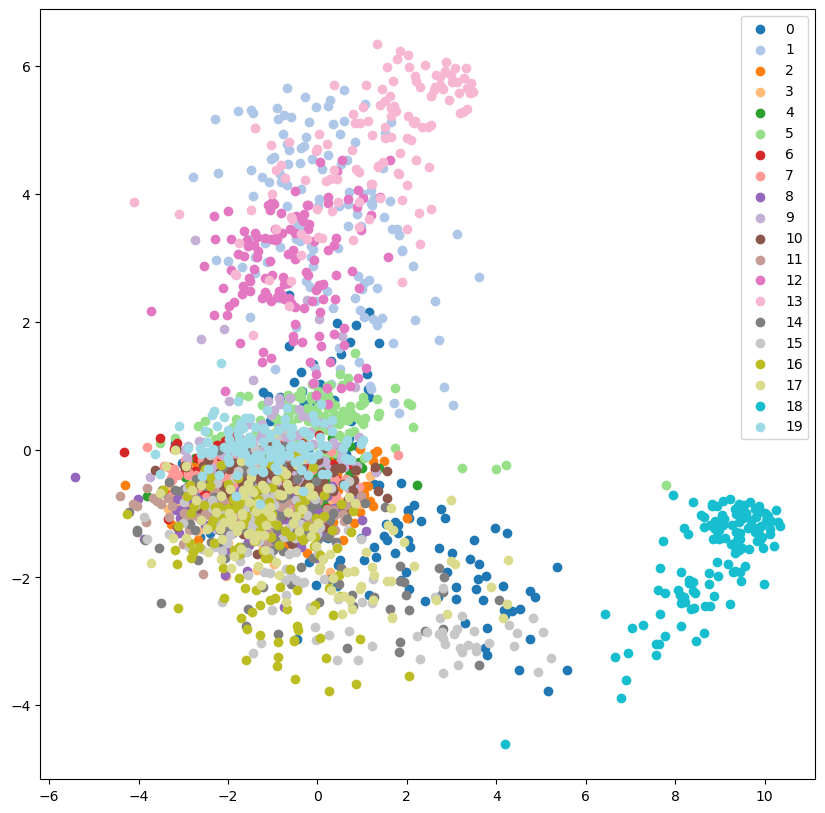

In [12]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA(n_components=2)
X_dr = pca.fit_transform(X)
fig, ax = plt.subplots(figsize=(10, 10))
cmap = plt.get_cmap('tab20')
for t in range(20):
    points = X_dr[t*2000: t*2000+128][y[t*2000: t*2000+128].astype(int) == t]
    ax.scatter(points[:, 0], points[:, 1], color=cmap(t), label=str(t))
ax.legend()

kmeans_results = cluster.fit_predict(X_dr)
print('Acc = {:.4f}'.format(cluster_acc(kmeans_results, y.astype(int))[0] * 100))

/tmp/ipykernel_3610513/1171392845.py:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('weight/300.pth'), strict=True)


torch.Size([60000, 768])


/home/RenPengju/.conda/envs/python310_pytorch/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Acc = 63.9400


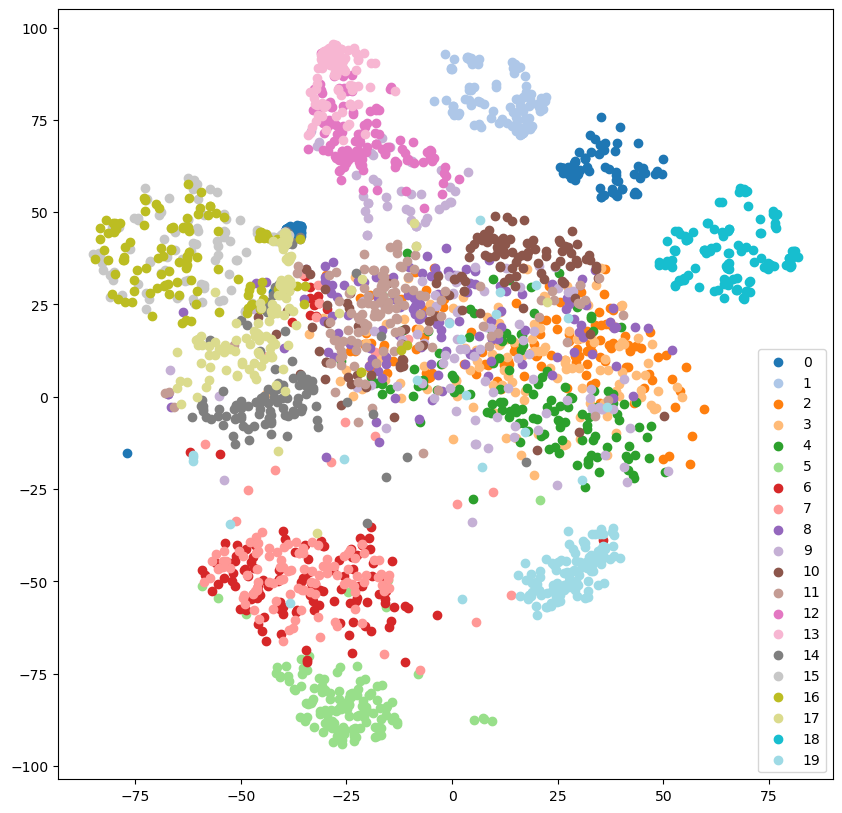

In [8]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from model import Spectra_MAE
from sklearn.cluster import KMeans


cluster = KMeans(n_clusters=30, random_state=0)

# Plot latent space 
xs, ts = plot_points[0].to('cuda:0'), plot_points[1].to('cuda:0')
model = Spectra_MAE.__dict__['spectraMAE_base_patch100']().to('cuda:0')
model.load_state_dict(torch.load('weight/300.pth'), strict=True)

# validloader = DataLoader(valset, batch_size=batch_size, num_workers=num_workers, shuffle=False, pin_memory=True)
latent, mask, ids_restore = model.forward_encoder(xs.unsqueeze(1), 0.5)
latent = latent.flatten(1, 2)
print(latent.shape)
# zs = model.encoder()
# print(xs.cpu().numpy().shape)

tsne = TSNE(n_components=2, init='pca')
zs_tsne = tsne.fit_transform(latent.cpu().detach().numpy())
# zs_tsne = tsne.fit_transform(xs.cpu().numpy())

fig, ax = plt.subplots(figsize=(10, 10))
cmap = plt.get_cmap('tab20')
for t in range(20):
    points = zs_tsne[t*2000: t*2000+128][y[t*2000: t*2000+128].astype(int) == t]
    ax.scatter(points[:, 0], points[:, 1], color=cmap(t), label=str(t))
ax.legend()

kmeans_results = cluster.fit_predict(zs_tsne)
print('Acc = {:.4f}'.format(cluster_acc(kmeans_results, plot_points[1].numpy())[0] * 100))